# demo

## 1. Library loading

In [325]:
import os
import re

#Processing data 
import numpy as np
import pandas as pd
import geopandas as gpd
pd.set_option('display.max_columns', None)
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns

## 2. Data processing

### 2.1 Reading and merging data

In [326]:
# Loading airbnb listings data
# Source link: 'http://insideairbnb.com/get-the-data/'
# If the link of listings.csv is not working, here is an alternative link 'https://raw.githubusercontent.com/Murphy829/CASA0013_A2_DEMO/main/Datasets/listings.csv'
df_airbnb = pd.read_csv('http://data.insideairbnb.com/united-kingdom/england/london/2022-09-10/visualisations/listings.csv')

In [327]:
# Selecting columns needed
df_airbnb_boroughs = df_airbnb.loc[:,['neighbourhood']]
df_counts = df_airbnb_boroughs.value_counts().rename_axis('BoroName').reset_index(name='ListingsCounts')
df_counts.head()

BoroName  ListingsCounts
0             Westminster            7763
1           Tower Hamlets            5595
2                 Hackney            5168
3                  Camden            4707
4  Kensington and Chelsea            4612

In [328]:
# Loading houseprice data
# Source link: 'https://www.statista.com/statistics/1029250/average-house-prices-in-london-united-kingdom-by-borough/'
df_houseprice = pd.read_csv('https://github.com/Murphy829/CASA0013_A2_DEMO/blob/main/Datasets/statistic_id1029250_average-house-prices-in-london-2021-2022-by-borough.csv?raw=true')

In [329]:
# Selecting columns needed
df_houseprice['HousepriceChange21-22'] = df_houseprice['Jun-22'] - df_houseprice['Jun-21']
df_houseprice.columns = ['BoroName','MeanHouselPrice2021','MeanHousePrice2022','HousepriceChange2122']
df_houseprice.head()

BoroName  MeanHouselPrice2021  MeanHousePrice2022  \
0  Kensington and Chelsea           1213616.63          1362055.48   
1     City of Westminster            858524.19           944440.75   
2          City of London            773731.64           830376.17   
3                  Camden            814597.11           829856.91   
4  Hammersmith and Fulham            736566.36           772446.89   

   HousepriceChange2122  
0             148438.85  
1              85916.56  
2              56644.53  
3              15259.80  
4              35880.53

In [330]:
# Change the boroname that don not match
df_houseprice.iloc[1,0] = 'Westminster'
df_houseprice.head()

BoroName  MeanHouselPrice2021  MeanHousePrice2022  \
0  Kensington and Chelsea           1213616.63          1362055.48   
1             Westminster            858524.19           944440.75   
2          City of London            773731.64           830376.17   
3                  Camden            814597.11           829856.91   
4  Hammersmith and Fulham            736566.36           772446.89   

   HousepriceChange2122  
0             148438.85  
1              85916.56  
2              56644.53  
3              15259.80  
4              35880.53

In [331]:
# Loading rental price data
# 2021 Source link: 'https://www.ons.gov.uk/peoplepopulationandcommunity/housing/bulletins/privaterentalmarketsummarystatisticsinengland/october2020toseptember2021'
# 2022 Source link: 'https://www.ons.gov.uk/peoplepopulationandcommunity/housing/bulletins/privaterentalmarketsummarystatisticsinengland/october2021toseptember2022'
df_rentalprice21 = pd.read_csv('https://github.com/Murphy829/CASA0013_A2_DEMO/blob/main/Datasets/Private_median_rental_prices_boro_2021.csv?raw=true')
df_rentalprice22 = pd.read_csv('https://github.com/Murphy829/CASA0013_A2_DEMO/blob/main/Datasets/Private_median_rental_prices_boro_2022.csv?raw=true')

In [332]:
# Selecting columns needed and merging data
df_rentalprice = pd.merge(left = df_rentalprice21,right=df_rentalprice22,how='left',left_on='Area Code1',right_on='Area Code1')
df_rentalprice = df_rentalprice.loc[:,['Area Code1','Area_x','All categories_x','All categories_y']]
df_rentalprice['RentalpriceChange21-22'] = df_rentalprice['All categories_y'] - df_rentalprice['All categories_x']
df_rentalprice.columns = ['gss_code','BoroName','MedRentalPrice2021','MedRentalPrice2022','RentalpriceChange2122']
df_rentalprice.head()

gss_code                BoroName  MedRentalPrice2021  MedRentalPrice2022  \
0  E09000007                  Camden                1675                1780   
1  E09000001          City of London                1684                1815   
2  E09000012                 Hackney                1600                1712   
3  E09000013  Hammersmith and Fulham                1647                1750   
4  E09000014                Haringey                1400                1475   

   RentalpriceChange2122  
0                    105  
1                    131  
2                    112  
3                    103  
4                     75

In [333]:
# Loading land use data
# 2022 Source link: 'https://www.gov.uk/government/statistics/land-use-in-england-2022'
df_landuse = pd.read_csv('https://github.com/Murphy829/CASA0013_A2_DEMO/blob/main/Datasets/Land%20Use%20by%20borough%20in%20London%202022.csv?raw=true')

In [334]:
# Selecting columns needed 
df_landuse = df_landuse.loc[:,['Name','Landuse_proportion_Community_service(2022)','Landuse_proportion_Industry_and_commerce(2022)','Landuse_proportion_Residential(2022)','Landuse_proportion_Transport_and_utilities(2022)']]
df_landuse.columns = ['BoroName','PropCommunity','PropCommerce','PropResidential','PropTransport']
df_landuse.head()

BoroName  PropCommunity  PropCommerce  PropResidential  \
0  Barking and Dagenham           5.76          5.42             9.69   
1                Barnet           5.44          0.89            10.23   
2                Bexley           4.86          2.37             9.56   
3                 Brent           5.59          3.92            13.93   
4               Bromley           3.59          0.53             6.23   

   PropTransport  
0          18.52  
1          14.84  
2          14.06  
3          21.26  
4          10.32

In [336]:
# Merging above dfs
from functools import reduce
df_groups = [df_counts,df_houseprice,df_rentalprice,df_landuse]
df_merged = reduce(lambda left, right: pd.merge(left, right, on=['BoroName']), df_groups)
df_merged.head()

BoroName  ListingsCounts  MeanHouselPrice2021  \
0             Westminster            7763            858524.19   
1           Tower Hamlets            5595            457109.46   
2                 Hackney            5168            580537.99   
3                  Camden            4707            814597.11   
4  Kensington and Chelsea            4612           1213616.63   

   MeanHousePrice2022  HousepriceChange2122   gss_code  MedRentalPrice2021  \
0           944440.75              85916.56  E09000033                2167   
1           484026.09              26916.63  E09000030                1550   
2           628689.94              48151.95  E09000012                1600   
3           829856.91              15259.80  E09000007                1675   
4          1362055.48             148438.85  E09000020                2171   

   MedRentalPrice2022  RentalpriceChange2122  PropCommunity  PropCommerce  \
0                2275                    108           3.89          8.36   
1                1650                    100           5.75          4.75   
2                1712                    112           5.40          2.78   
3                1780                    105           5.49          4.19   
4                2300                    129           7.18          3.29   

   PropResidential  PropTransport  
0            17.56          26.39  
1            15.55          24.37  
2            18.27          21.89  
3            15.93          23.09  
4            23.32          27.53

### 2.2 Describing data

In [337]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 0 to 32
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   BoroName               33 non-null     object 
 1   ListingsCounts         33 non-null     int64  
 2   MeanHouselPrice2021    33 non-null     float64
 3   MeanHousePrice2022     33 non-null     float64
 4   HousepriceChange2122   33 non-null     float64
 5   gss_code               33 non-null     object 
 6   MedRentalPrice2021     33 non-null     int64  
 7   MedRentalPrice2022     33 non-null     int64  
 8   RentalpriceChange2122  33 non-null     int64  
 9   PropCommunity          33 non-null     float64
 10  PropCommerce           33 non-null     float64
 11  PropResidential        33 non-null     float64
 12  PropTransport          33 non-null     float64
dtypes: float64(7), int64(4), object(2)
memory usage: 3.6+ KB


In [338]:
df_merged.describe()

ListingsCounts  MeanHouselPrice2021  MeanHousePrice2022  \
count       33.000000         3.300000e+01        3.300000e+01   
mean      2101.545455         5.403502e+05        5.793530e+05   
std       1875.066684         1.800360e+05        2.002025e+05   
min        286.000000         3.140189e+05        3.420835e+05   
25%        617.000000         4.260040e+05        4.535521e+05   
50%       1514.000000         4.991733e+05        5.280874e+05   
75%       3473.000000         5.805380e+05        6.286899e+05   
max       7763.000000         1.213617e+06        1.362055e+06   

       HousepriceChange2122  MedRentalPrice2021  MedRentalPrice2022  \
count             33.000000           33.000000           33.000000   
mean           39002.713030         1450.030303         1517.606061   
std            25852.778247          251.385844          278.372944   
min            10581.340000         1100.000000         1150.000000   
25%            26916.630000         1300.000000         1315.000000   
50%            34216.570000         1400.000000         1450.000000   
75%            41713.600000         1600.000000         1700.000000   
max           148438.850000         2171.000000         2300.000000   

       RentalpriceChange2122  PropCommunity  PropCommerce  PropResidential  \
count              33.000000      33.000000     33.000000        33.000000   
mean               67.575758       5.290909      3.123636        12.805455   
std                36.827325       1.304493      3.140856         4.446123   
min               -13.000000       2.800000      0.530000         5.870000   
25%                50.000000       4.410000      1.410000         9.690000   
50%                50.000000       5.050000      2.370000        11.760000   
75%               100.000000       5.750000      3.730000        15.930000   
max               131.000000       8.910000     18.100000        23.320000   

       PropTransport  
count      33.000000  
mean       19.031818  
std         5.359646  
min        10.320000  
25%        14.710000  
50%        18.520000  
75%        22.870000  
max        32.060000

### 2.3 Dealing with Nulls and Nulls

In [339]:
# Dealing with Nulls
df_merged.isnull().sum()

BoroName                 0
ListingsCounts           0
MeanHouselPrice2021      0
MeanHousePrice2022       0
HousepriceChange2122     0
gss_code                 0
MedRentalPrice2021       0
MedRentalPrice2022       0
RentalpriceChange2122    0
PropCommunity            0
PropCommerce             0
PropResidential          0
PropTransport            0
dtype: int64

In [341]:
# Dealing with NaNs
df_merged.isna().sum()

BoroName                 0
ListingsCounts           0
MeanHouselPrice2021      0
MeanHousePrice2022       0
HousepriceChange2122     0
gss_code                 0
MedRentalPrice2021       0
MedRentalPrice2022       0
RentalpriceChange2122    0
PropCommunity            0
PropCommerce             0
PropResidential          0
PropTransport            0
dtype: int64

### 2.4 Saving the files to local disk

In [344]:
# Saving the csv files to local disk
df_merged.to_csv(r'df_merged.csv', index = True, header = True, mode = 'a')

## 3. Visualisation

### 3.1 Distribution of listings

In [343]:
# Read London borough shape
# London borough boundaries shape data originally from 'https://data.london.gov.uk/download/london_boroughs/9502cdec-5df0-46e3-8aa1-2b5c5233a31f/London_Boroughs.gpkg'
boros = gpd.read_file('https://github.com/Murphy829/CASA0013_A2_DEMO/blob/main/Datasets/London_Boroughs.gpkg?raw=true')

In [345]:
# Merging csv and shapefile
gdf = gpd.GeoDataFrame(df_merged.merge(boros, on='gss_code'))
gdf.head()

BoroName  ListingsCounts  MeanHouselPrice2021  \
0             Westminster            7763            858524.19   
1           Tower Hamlets            5595            457109.46   
2                 Hackney            5168            580537.99   
3                  Camden            4707            814597.11   
4  Kensington and Chelsea            4612           1213616.63   

   MeanHousePrice2022  HousepriceChange2122   gss_code  MedRentalPrice2021  \
0           944440.75              85916.56  E09000033                2167   
1           484026.09              26916.63  E09000030                1550   
2           628689.94              48151.95  E09000012                1600   
3           829856.91              15259.80  E09000007                1675   
4          1362055.48             148438.85  E09000020                2171   

   MedRentalPrice2022  RentalpriceChange2122  PropCommunity  PropCommerce  \
0                2275                    108           3.89          8.36   
1                1650                    100           5.75          4.75   
2                1712                    112           5.40          2.78   
3                1780                    105           5.49          4.19   
4                2300                    129           7.18          3.29   

   PropResidential  PropTransport  objectid                    name  hectares  \
0            17.56          26.39        26             Westminster  2203.005   
1            15.55          24.37        28           Tower Hamlets  2157.501   
2            18.27          21.89        30                 Hackney  1904.902   
3            15.93          23.09        27                  Camden  2178.932   
4            23.32          27.53        24  Kensington and Chelsea  1238.379   

   nonld_area ons_inner sub_2011  \
0      54.308         T  Central   
1     178.867         T     East   
2       0.000         T     East   
3       0.000         T  Central   
4      25.994         T  Central   

                                            geometry  
0  POLYGON ((530410.600 178958.500, 530407.500 17...  
1  POLYGON ((536853.000 179077.800, 536843.800 17...  
2  POLYGON ((531928.400 187801.500, 531935.700 18...  
3  POLYGON ((528840.200 187217.800, 528834.600 18...  
4  POLYGON ((525723.800 177575.100, 525718.800 17...

In [346]:
# Dropping duplicate columns
gdf = gdf.drop('name',axis=1)
gdf.head()

BoroName  ListingsCounts  MeanHouselPrice2021  \
0             Westminster            7763            858524.19   
1           Tower Hamlets            5595            457109.46   
2                 Hackney            5168            580537.99   
3                  Camden            4707            814597.11   
4  Kensington and Chelsea            4612           1213616.63   

   MeanHousePrice2022  HousepriceChange2122   gss_code  MedRentalPrice2021  \
0           944440.75              85916.56  E09000033                2167   
1           484026.09              26916.63  E09000030                1550   
2           628689.94              48151.95  E09000012                1600   
3           829856.91              15259.80  E09000007                1675   
4          1362055.48             148438.85  E09000020                2171   

   MedRentalPrice2022  RentalpriceChange2122  PropCommunity  PropCommerce  \
0                2275                    108           3.89          8.36   
1                1650                    100           5.75          4.75   
2                1712                    112           5.40          2.78   
3                1780                    105           5.49          4.19   
4                2300                    129           7.18          3.29   

   PropResidential  PropTransport  objectid  hectares  nonld_area ons_inner  \
0            17.56          26.39        26  2203.005      54.308         T   
1            15.55          24.37        28  2157.501     178.867         T   
2            18.27          21.89        30  1904.902       0.000         T   
3            15.93          23.09        27  2178.932       0.000         T   
4            23.32          27.53        24  1238.379      25.994         T   

  sub_2011                                           geometry  
0  Central  POLYGON ((530410.600 178958.500, 530407.500 17...  
1     East  POLYGON ((536853.000 179077.800, 536843.800 17...  
2     East  POLYGON ((531928.400 187801.500, 531935.700 18...  
3  Central  POLYGON ((528840.200 187217.800, 528834.600 18...  
4  Central  POLYGON ((525723.800 177575.100, 525718.800 17...

In [347]:
gdf.head()

BoroName  ListingsCounts  MeanHouselPrice2021  \
0             Westminster            7763            858524.19   
1           Tower Hamlets            5595            457109.46   
2                 Hackney            5168            580537.99   
3                  Camden            4707            814597.11   
4  Kensington and Chelsea            4612           1213616.63   

   MeanHousePrice2022  HousepriceChange2122   gss_code  MedRentalPrice2021  \
0           944440.75              85916.56  E09000033                2167   
1           484026.09              26916.63  E09000030                1550   
2           628689.94              48151.95  E09000012                1600   
3           829856.91              15259.80  E09000007                1675   
4          1362055.48             148438.85  E09000020                2171   

   MedRentalPrice2022  RentalpriceChange2122  PropCommunity  PropCommerce  \
0                2275                    108           3.89          8.36   
1                1650                    100           5.75          4.75   
2                1712                    112           5.40          2.78   
3                1780                    105           5.49          4.19   
4                2300                    129           7.18          3.29   

   PropResidential  PropTransport  objectid  hectares  nonld_area ons_inner  \
0            17.56          26.39        26  2203.005      54.308         T   
1            15.55          24.37        28  2157.501     178.867         T   
2            18.27          21.89        30  1904.902       0.000         T   
3            15.93          23.09        27  2178.932       0.000         T   
4            23.32          27.53        24  1238.379      25.994         T   

  sub_2011                                           geometry  
0  Central  POLYGON ((530410.600 178958.500, 530407.500 17...  
1     East  POLYGON ((536853.000 179077.800, 536843.800 17...  
2     East  POLYGON ((531928.400 187801.500, 531935.700 18...  
3  Central  POLYGON ((528840.200 187217.800, 528834.600 18...  
4  Central  POLYGON ((525723.800 177575.100, 525718.800 17...

In [348]:
# Setting coordinate
gdf = gdf.to_crs('epsg:27700')

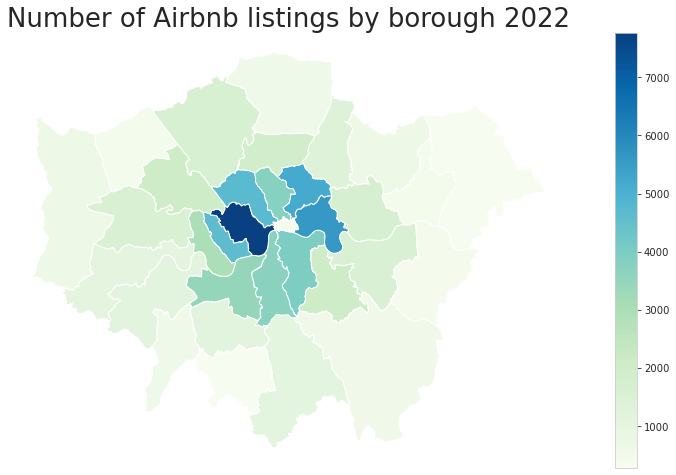

In [349]:
gdf.plot(column='ListingsCounts', legend=True, figsize=(16,8),cmap="GnBu")
plt.title("Number of Airbnb listings by borough 2022", fontsize=26)
plt.axis('off')
plt.savefig("Number_of_listings_map_2022.jpg",bbox_inches = 'tight',dpi=200)

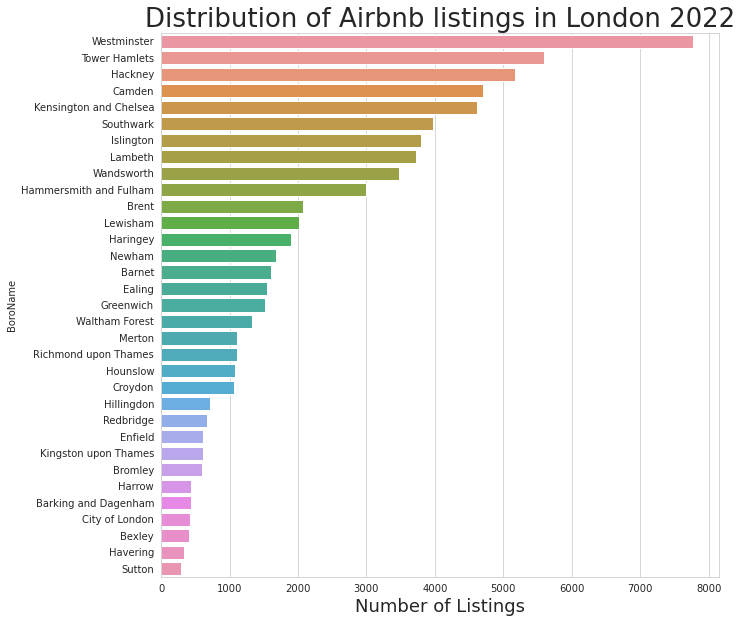

In [350]:
plt.figure(figsize=(10,10))
sns.barplot(x="ListingsCounts", y="BoroName", data=gdf)
plt.title("Distribution of Airbnb listings in London 2022",fontsize=26)
plt.xlabel("Number of Listings",fontsize=18)
plt.savefig("Distribution_of_Airbnb_listings_in_London_2022.jpg", bbox_inches = 'tight',dpi=200)

### 3.2 Fluctuations of average house price 2021-2022

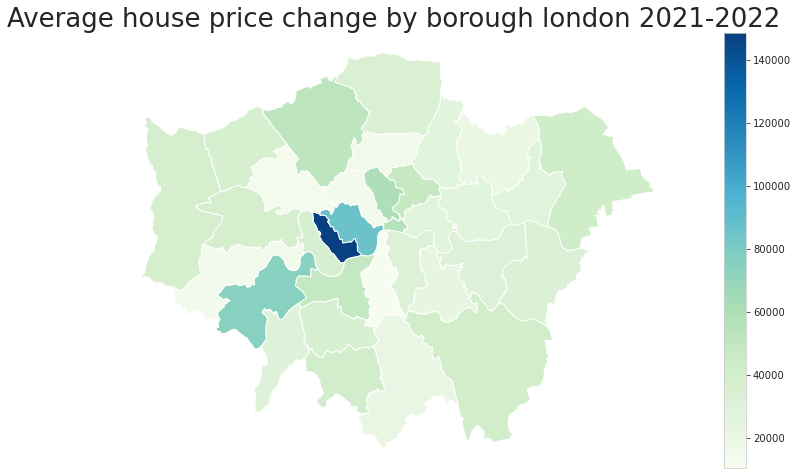

In [351]:
gdf.plot(column='HousepriceChange2122', legend=True, figsize=(16,8),cmap="GnBu")
plt.title("Average house price change by borough london 2021-2022 ", fontsize=26)
plt.axis('off')
plt.savefig("Average_house_price_change_by_borough_london_2021-2022.jpg",bbox_inches = 'tight',dpi=200)

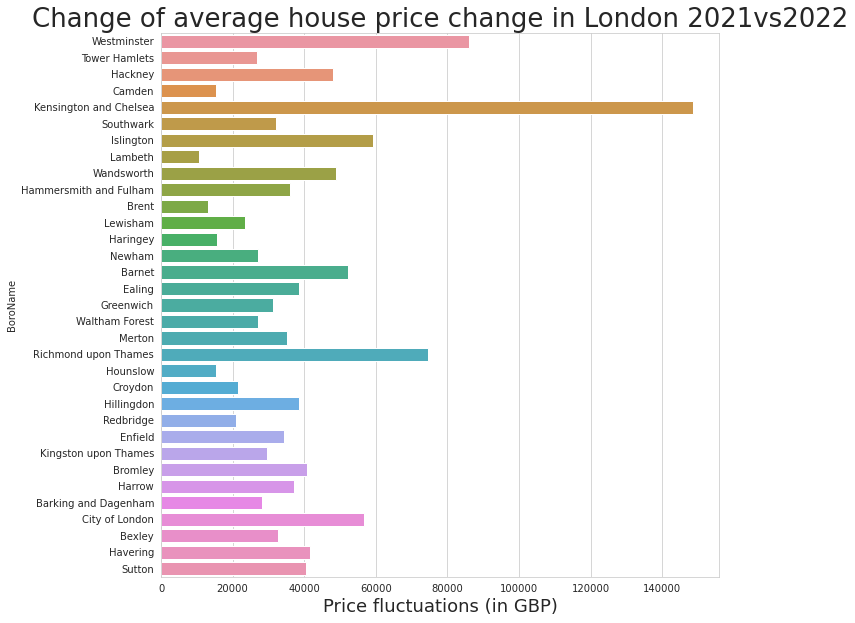

In [352]:
# Plot house price change
plt.figure(figsize=(10,10))
sns.barplot(x="HousepriceChange2122", y="BoroName", data=gdf)
plt.title("Change of average house price change in London 2021vs2022",fontsize=26)
plt.xlabel("Price fluctuations (in GBP)",fontsize=18)
plt.savefig("Change_of_average_house_price_change_in_London_2021vs2022.jpg", bbox_inches = 'tight',dpi=200)

### 3.3 Fluctuations of median rental price 2021-2022

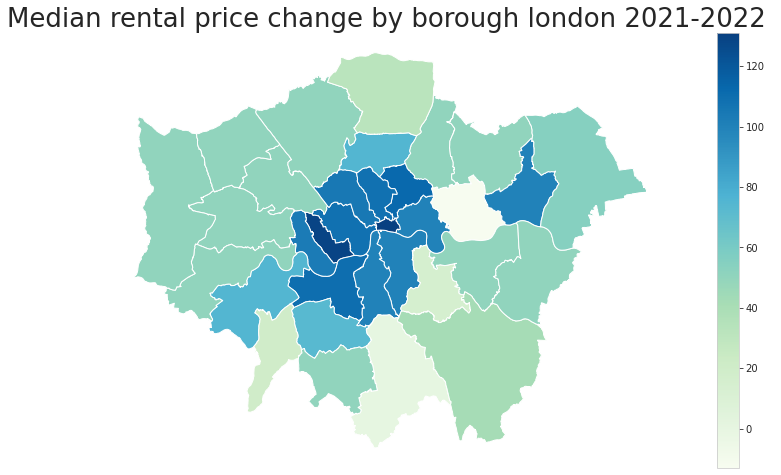

In [353]:
gdf.plot(column='RentalpriceChange2122', legend=True, figsize=(16,8),cmap="GnBu")
plt.title("Median rental price change by borough london 2021-2022 ", fontsize=26)
plt.axis('off')
plt.savefig("Median_reantal_price_change_by_borough_london_2021-2022.jpg",bbox_inches = 'tight',dpi=200)

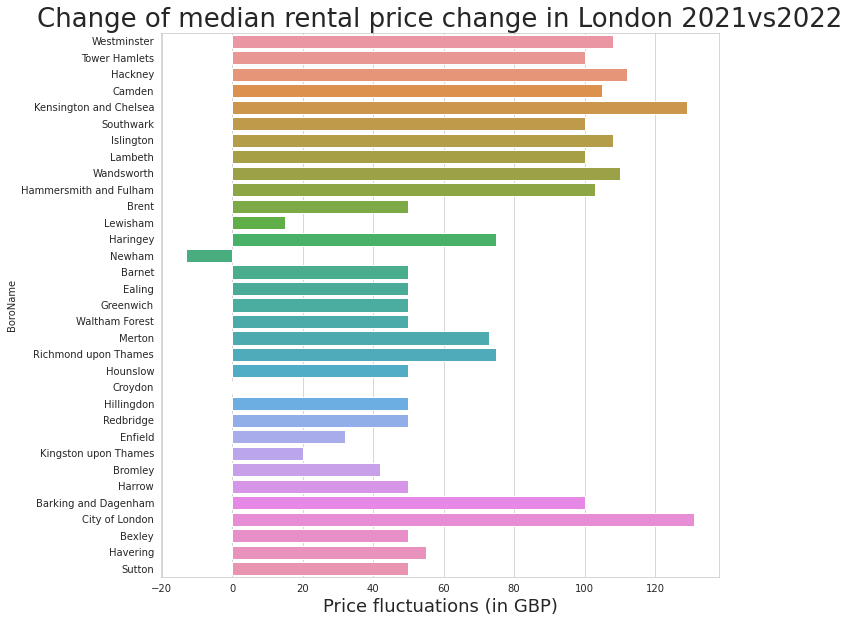

In [354]:
# Plot rental price change
plt.figure(figsize=(10,10))
sns.barplot(x="RentalpriceChange2122", y="BoroName", data=gdf)
plt.title("Change of median rental price change in London 2021vs2022",fontsize=26)
plt.xlabel("Price fluctuations (in GBP)",fontsize=18)
plt.savefig("Change_of_median_rental_price_change_in_London_2021vs2022.jpg", bbox_inches = 'tight',dpi=200)

### 3.4 Calculationg Pearson correlation

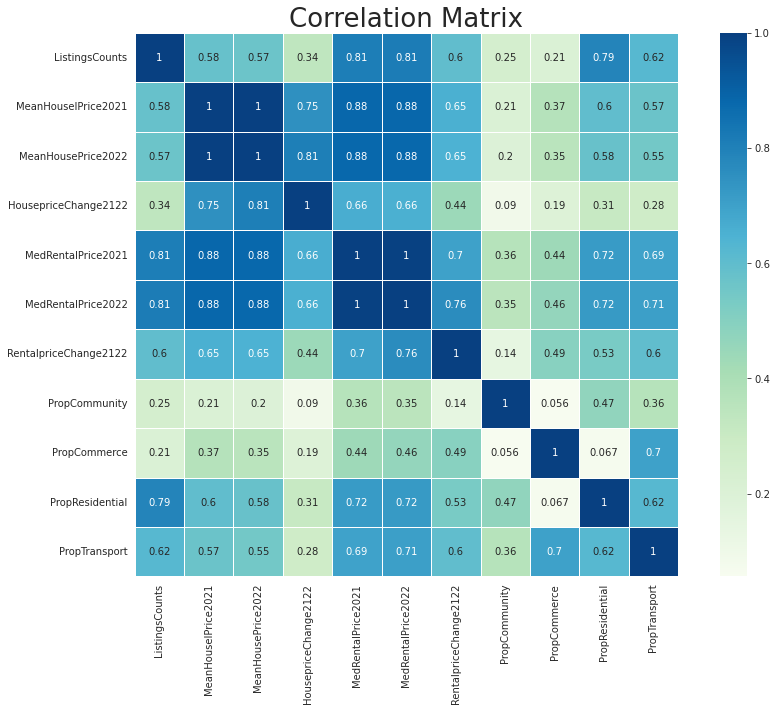

In [356]:
# Check the correlations
df_abs=df_merged.corr().abs()
plt.figure(figsize=(15, 10))
plt.title('Correlation Matrix',fontdict={'fontsize':26})
sns.heatmap(df_abs, 
           cmap='GnBu',
           vmax=1,
           square=True,
           annot=True,
           linewidths=.5)
plt.savefig("Correlation Matrix.jpg",bbox_inches = 'tight',dpi=200)

### 3.5 Handling multicollinearity

In [357]:
# Checking VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant


df_demo = df_merged.loc[:,['ListingsCounts','PropCommunity','PropCommerce','PropResidential','PropTransport']]

df_check = df_check = df_demo[list(df_demo)]
df_with_const = add_constant(df_check)

vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()
vif_df = vif_df.drop('const')
vif_df

VIF
ListingsCounts   3.061774
PropCommunity    1.413123
PropCommerce     3.554884
PropResidential  4.700966
PropTransport    5.982382

In [358]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly 
    the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [359]:
# Dropping variables affected by multicollinearity
df_merged_new = drop_column_using_vif_(df_merged.loc[:,['ListingsCounts','PropCommunity','PropCommerce','PropResidential','PropTransport']])

Dropping: PropTransport


In [360]:
df_merged_new = df_merged.drop('PropTransport',axis=1)
df_merged_new.head()

BoroName  ListingsCounts  MeanHouselPrice2021  \
0             Westminster            7763            858524.19   
1           Tower Hamlets            5595            457109.46   
2                 Hackney            5168            580537.99   
3                  Camden            4707            814597.11   
4  Kensington and Chelsea            4612           1213616.63   

   MeanHousePrice2022  HousepriceChange2122   gss_code  MedRentalPrice2021  \
0           944440.75              85916.56  E09000033                2167   
1           484026.09              26916.63  E09000030                1550   
2           628689.94              48151.95  E09000012                1600   
3           829856.91              15259.80  E09000007                1675   
4          1362055.48             148438.85  E09000020                2171   

   MedRentalPrice2022  RentalpriceChange2122  PropCommunity  PropCommerce  \
0                2275                    108           3.89          8.36   
1                1650                    100           5.75          4.75   
2                1712                    112           5.40          2.78   
3                1780                    105           5.49          4.19   
4                2300                    129           7.18          3.29   

   PropResidential  
0            17.56  
1            15.55  
2            18.27  
3            15.93  
4            23.32

 ### 3.6 Formating regression model

In [376]:
# Formating regression model for house price using OLS
model_Houseprice = sm.formula.ols('HousepriceChange2122 ~ ListingsCounts + PropCommunity + PropCommerce + PropResidential', df_merged_new).fit()
model_Houseprice.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     HousepriceChange2122   R-squared:                       0.138
Model:                              OLS   Adj. R-squared:                  0.015
Method:                   Least Squares   F-statistic:                     1.125
Date:                  Tue, 17 Jan 2023   Prob (F-statistic):              0.365
Time:                          08:55:29   Log-Likelihood:                -379.14
No. Observations:                    33   AIC:                             768.3
Df Residuals:                        28   BIC:                             775.8
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2.151e+04   2.09e+04      1.030      0.312   -2.13e+04    6.43e+04
ListingsCounts      2.3615      4.183      0.565      0.577      -6.207      10.930
PropCommunity    -950.2010   4064.688     -0.234      0.817   -9276.338    7375.936
PropCommerce     1213.0050   1502.134      0.808      0.426   -1863.976    4289.986
PropResidential  1075.5025   1900.201      0.566      0.576   -2816.883    4967.888
==============================================================================
Omnibus:                       26.453   Durbin-Watson:                   2.487
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.510
Skew:                           1.777   Prob(JB):                     1.97e-13
Kurtosis:                       8.470   Cond. No.                     1.32e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [375]:
# Formating regression model for rental price using OLS
model_Rentalprice = sm.formula.ols('RentalpriceChange2122 ~ ListingsCounts + PropCommunity + PropCommerce + PropResidential', df_merged_new).fit()
model_Rentalprice.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     RentalpriceChange2122   R-squared:                       0.534
Model:                               OLS   Adj. R-squared:                  0.468
Method:                    Least Squares   F-statistic:                     8.038
Date:                   Tue, 17 Jan 2023   Prob (F-statistic):           0.000190
Time:                           08:55:25   Log-Likelihood:                -152.71
No. Observations:                     33   AIC:                             315.4
Df Residuals:                         28   BIC:                             322.9
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          20.7838     21.869      0.950      0.350     -24.013      65.581
ListingsCounts      0.0051      0.004      1.171      0.251      -0.004       0.014
PropCommunity      -3.1302      4.256     -0.735      0.468     -11.849       5.588
PropCommerce        4.9408      1.573      3.141      0.004       1.719       8.163
PropResidential     2.9003      1.990      1.458      0.156      -1.175       6.976
==============================================================================
Omnibus:                        8.563   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                7.070
Skew:                          -1.000   Prob(JB):                       0.0292
Kurtosis:                       4.069   Cond. No.                     1.32e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 4. Tests

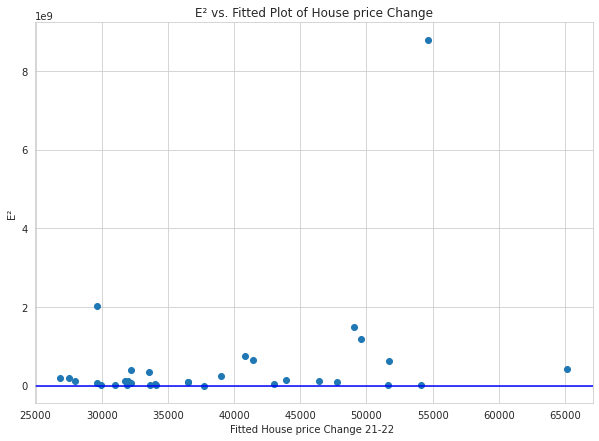

In [377]:
# Heteroscedasticity detection
# Graphical test

model_res = sm.formula.ols('HousepriceChange2122 ~ ListingsCounts + PropCommunity + PropCommerce + PropResidential', df_merged_new).fit()

res = model_res.resid
fitted = model_res.fittedvalues
e2 = res**2

plt.figure(figsize=(10, 7))
plt.scatter(fitted, e2)

# adding title and labels
plt.xlabel('Fitted House price Change 21-22 ')
plt.ylabel('E²')
plt.title('E² vs. Fitted Plot of House price Change')

plt.axhline(y = 0.0, color = 'b',linestyle = '-')
plt.show()

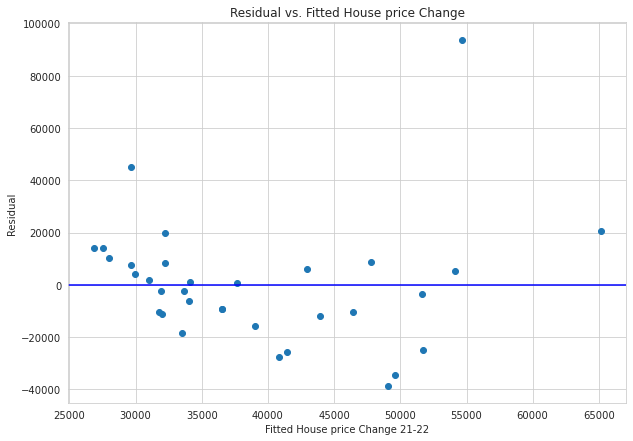

In [378]:
# Residual analysis
plt.figure(figsize=(10,7))
plt.scatter(model_Houseprice.fittedvalues, model_Houseprice.resid)
# adding title and labels
plt.xlabel('Fitted House price Change 21-22')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted House price Change')

plt.axhline(y = 0, color = 'b',linestyle = '-')
plt.show()

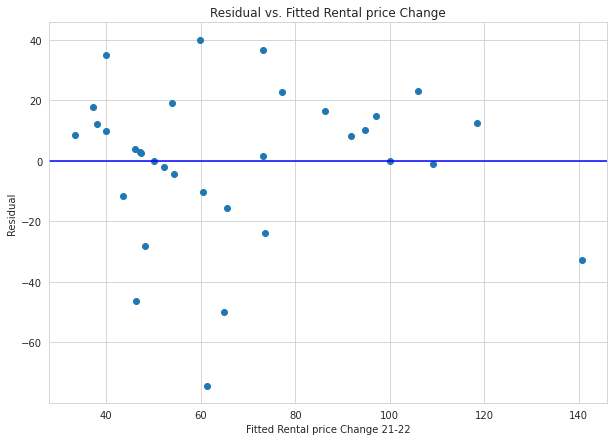

In [379]:
# Residual analysis
plt.figure(figsize=(10,7))
plt.scatter(model_Rentalprice.fittedvalues, model_Rentalprice.resid)
# adding title and labels
plt.xlabel('Fitted Rental price Change 21-22')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Rental price Change')

plt.axhline(y = 0, color = 'b',linestyle = '-')
plt.show()

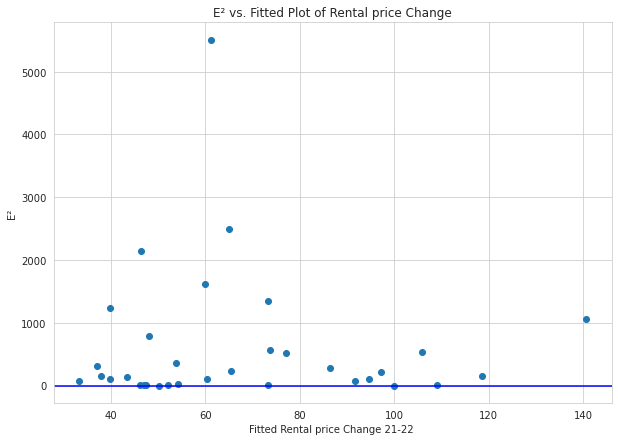

In [380]:
# Heteroscedasticity detection
# Graphical test

model_res = sm.formula.ols('RentalpriceChange2122 ~ ListingsCounts + PropCommunity + PropCommerce + PropResidential', df_merged_new).fit()

res = model_res.resid
fitted = model_res.fittedvalues
e2 = res**2

plt.figure(figsize=(10, 7))
plt.scatter(fitted, e2)

# adding title and labels
plt.xlabel('Fitted Rental price Change 21-22 ')
plt.ylabel('E²')
plt.title('E² vs. Fitted Plot of Rental price Change')

plt.axhline(y = 0.0, color = 'b',linestyle = '-')
plt.show()